In [1]:
from scipy.special import comb, perm
from scipy import integrate
from scipy.stats import norm, laplace
import numpy as np

from autodp import rdp_bank, rdp_acct, dp_acct, privacy_calibrator

from decimal import *

getcontext().prec = 1024

In [2]:
def integrand(x, alpha, sigma, m, probs):
    sum_ = 0.0
    for i in range(m+1):
        sum_ += probs[i]*norm.pdf(x, loc=i, scale=sigma)
    sum_ /= norm.pdf(x, loc=0, scale=sigma)
    sum_ = (sum_ ** alpha) * norm.pdf(x, loc=0, scale=sigma)
    return sum_

def compute_group_rdp(alpha, sigma, q, m):
    probs = [comb(m, i) * (1-q)**(m-i) * q**i for i in range(m+1)]
    I = integrate.quad(integrand, -sigma*10, sigma*10, args=(alpha, sigma, m, probs))
    return np.log(I[0]) / (alpha-1)

In [3]:
def rdp2dp(rdp, bad_event, alpha):
    """
    convert RDP to DP, ref (Proposition 12):
    Canonne, Clément L., Gautam Kamath, and Thomas Steinke. The discrete gaussian for differential privacy. In NeurIPS, 2020.
    """
    eps_dp = Decimal(rdp) + Decimal(1.0)/Decimal(alpha-1) * ((Decimal(1.0)/Decimal(bad_event)).ln() + Decimal(alpha-1)*Decimal(1-1.0/alpha).ln() - Decimal(alpha).ln())
    return float(eps_dp)

def naive_group_rdp(alpha, sigma, q, m):
    """
    Suppose m=2^c for c \in Z
    """
    alpha = alpha * m

    func_gaussian = lambda x: rdp_bank.RDP_gaussian({'sigma': sigma}, x)

    # declare the moment accountants
    acct1 = rdp_acct.anaRDPacct()

    acct1.compose_poisson_subsampled_mechanisms(func_gaussian, q, coeff=1)

    rdp = acct1.get_rdp([alpha])[0]
    
    c = np.log2(m)
    
    return float(3**c * rdp)

def exact_rdp_upd(alpha, sigma, q, m):
    sum_ = Decimal(0.0)
    
    p_r = [Decimal(comb(m, k, exact=True)) * Decimal(q)**Decimal(k) * Decimal(1-q)**Decimal(m-k) for k in range(0, m+1)]
    
    for i in range(0, m+1):
        sum_ +=  p_r[i]*Decimal(np.e)**(Decimal((alpha-1)*alpha*i**2)/Decimal(2*sigma**2))
    rdp = sum_.ln() / Decimal(alpha-1)
    return float(rdp)

In [4]:
def calibrating_sgm_noise_lbd(q, m, alpha=4, tau=0.5, t=1, err=1e-4):
    """
    Calibrate noise to privacy budgets
    """
    sigma_max = 5000
    sigma_min = 2
    
    def binary_search(left, right):
        mid = (left + right) / 2
        
        lbd = t*compute_group_rdp(alpha, mid, q, m)
        ubd = t*compute_group_rdp(alpha, left, q, m)
        
        if ubd > tau and lbd > tau:    # min noise & mid noise are too small
            left = mid
        elif ubd > tau and lbd < tau:  # mid noise is too large
            right = mid
        else:
            print("an error occurs in binary search")
            return -1
        return left, right
        
    # check
    while t*compute_group_rdp(alpha, sigma_max, q, m) > tau:
        sigma_max *= 10
        if sigma_max > 1e10:
            print("sigma_max >", sigma_max)
            return -1
    
    while sigma_max-sigma_min > err:
        sigma_min, sigma_max = binary_search(sigma_min, sigma_max)
    return sigma_max

def calibrating_sgm_noise_naive(q, m, alpha=4, tau=0.5, t=1, err=1e-4):
    """
    Calibrate noise to privacy budgets
    """
    sigma_max = 5000
    sigma_min = 8
    
    def binary_search(left, right):
        mid = (left + right) / 2
        
        lbd = t*naive_group_rdp(alpha, mid, q, m)
        ubd = t*naive_group_rdp(alpha, left, q, m)
        
        if ubd > tau and lbd > tau:    # min noise & mid noise are too small
            left = mid
        elif ubd > tau and lbd < tau:  # mid noise is too large
            right = mid
        else:
            print("an error occurs in binary search")
            return -1
        return left, right
        
    # check
    while t*naive_group_rdp(alpha, sigma_max, q, m) > tau:
        sigma_max *= 10
        if sigma_max > 1e10:
            print("sigma_max >", sigma_max)
            return -1
    
    while sigma_max-sigma_min > err:
        sigma_min, sigma_max = binary_search(sigma_min, sigma_max)
    return sigma_max


def calibrating_sgm_noise_ours(q, m, alpha=4, tau=0.5, t=1, err=1e-4):
    """
    Calibrate noise to privacy budgets
    """
    sigma_max = 5000
    sigma_min = 8
    
    def binary_search(left, right):
        mid = (left + right) / 2
        
        lbd = t*exact_rdp_upd(alpha, mid, q, m)
        ubd = t*exact_rdp_upd(alpha, left, q, m)
        
        if ubd > tau and lbd > tau:    # min noise & mid noise are too small
            left = mid
        elif ubd > tau and lbd < tau:  # mid noise is too large
            right = mid
        else:
            print("an error occurs in binary search")
            return -1
        return left, right
        
    # check
    while t*exact_rdp_upd(alpha, sigma_max, q, m) > tau:
        sigma_max *= 10
        if sigma_max > 1e10:
            print("sigma_max >", sigma_max)
            return -1
    
    while sigma_max-sigma_min > err:
        sigma_min, sigma_max = binary_search(sigma_min, sigma_max)
    return sigma_max

## Subsmapled Gaussian - Varying $m$

In [5]:
q = 0.03

iters = 500

m_list = [16, 32, 64, 128, 256]

alpha = 4
tau = 1

delta = 1e-5

naive_list = []
upd_list = []
lbd_list = []

dp_eps = rdp2dp(tau,delta,alpha)
print( "alpha={},tau={},eps={},".format(alpha, tau, dp_eps) )

for m in m_list:
    naive = 1e10
    if abs(np.log2(m)-int(np.log2(m))) < 0.00001:
        naive = calibrating_sgm_noise_naive(q, m, alpha=alpha, tau=tau, t=iters, err=1e-1)
    upd = calibrating_sgm_noise_ours(q, m, alpha=alpha, tau=tau, t=iters, err=1e-1)
    lbd = calibrating_sgm_noise_lbd(q, m, alpha=alpha, tau=tau, t=iters, err=1e-1)
    print("m={}, naive={},upd={},lbd={}".format(m, naive, upd, lbd))
    print("")
    naive_list.append(naive)
    upd_list.append(upd)
    lbd_list.append(lbd)

alpha=4,tau=1,eps=4.087861628831665,
m=16, naive=34.203125,upd=26.5859375,lbd=15.26983642578125

m=32, naive=83.71484375,upd=43.267578125,lbd=30.446258544921875

m=64, naive=204.98046875,upd=74.7265625,lbd=60.799102783203125

m=128, naive=501.974609375,upd=136.12109375,lbd=121.50479125976562

m=256, naive=1229.568359375,upd=257.99609375,lbd=242.91616821289062



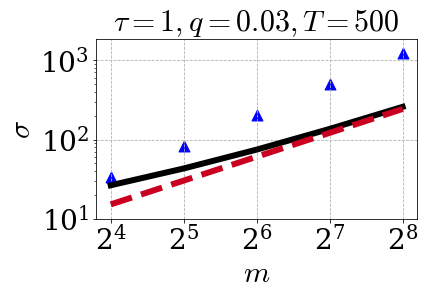

In [6]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
import numpy as np


plt.figure(figsize=(6, 4.2))

plt.rcParams['mathtext.fontset'] = 'cm'


{'cursive', 'fantasy', 'monospace', 'sans', 'sans serif', 'sans-serif', 'serif'}

hfont = {'fontname':'serif'}

plt.xlabel(r'$m$', fontsize=30, **hfont)
plt.xticks(fontsize=28, **hfont)
plt.ylabel(r'$\sigma$', fontsize=30)
plt.yticks(fontsize=28, **hfont)

plt.scatter(m_list, naive_list, label='Baseline', c='b', marker='^', s=120)
plt.plot(m_list, upd_list, lw=6, label='Ours', c='black')
plt.plot(m_list, lbd_list, lw=6, label='Lower Bound', c='#ca0020', ls='--')

plt.grid(axis='x',linestyle='--')
plt.grid(axis='y',linestyle='--')



plt.yscale('log', base=10)
plt.xscale('log', base=2)

plt.ylim((10, naive_list[-1]*1.5))

plt.title(r'$\tau={}, q={}, T={}$'.format(tau, q, iters), fontsize = 30)


plt.tight_layout()


#plt.savefig('figures/sgm_rdp_m.jpg', dpi=300)
#plt.savefig('figures/sgm_rdp_m.pdf', format='pdf', transparent=True)

plt.show()

## Varying $\tau$

In [7]:
#alpha = 16
sigma = 32
q = 0.03
m = 64

iters = 500

tau_list = [0.25, 0.5, 1.0, 2, 4]

alpha = 4
tau = 1

delta = 1e-5

naive_list = []
upd_list = []
lbd_list = []


for tau in tau_list:
    naive = calibrating_sgm_noise_naive(q, m, alpha=alpha, tau=tau, t=iters, err=1e-1)
    upd = calibrating_sgm_noise_ours(q, m, alpha=alpha, tau=tau, t=iters, err=1e-1)
    lbd = calibrating_sgm_noise_lbd(q, m, alpha=alpha, tau=tau, t=iters, err=1e-1)
    print("tau={}, naive={},upd={},lbd={}".format(tau, naive, upd, lbd))
    print("eps={}".format(rdp2dp(tau,delta,alpha)) )
    print("")
    naive_list.append(naive)
    upd_list.append(upd)
    lbd_list.append(lbd)

tau=0.25, naive=409.8828125,upd=149.0703125,lbd=121.50479125976562
eps=3.337861628831665

tau=0.5, naive=289.8359375,upd=105.5,lbd=85.96603393554688
eps=3.587861628831665

tau=1.0, naive=204.98046875,upd=74.7265625,lbd=60.799102783203125
eps=4.087861628831665

tau=2, naive=144.95703125,upd=52.94140625,lbd=43.02972412109375
eps=5.087861628831665

tau=4, naive=102.529296875,upd=37.630859375,lbd=30.52252197265625
eps=7.087861628831665



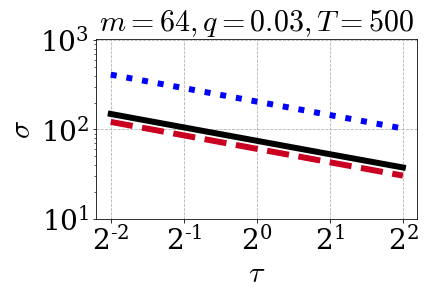

In [8]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
import numpy as np


plt.figure(figsize=(6, 4.2))

plt.rcParams['mathtext.fontset'] = 'cm'


{'cursive', 'fantasy', 'monospace', 'sans', 'sans serif', 'sans-serif', 'serif'}

hfont = {'fontname':'serif'}

plt.xlabel(r'$\tau$', fontsize=30, **hfont)
plt.xticks(fontsize=28, **hfont)
plt.ylabel(r'$\sigma$', fontsize=30)
plt.yticks(fontsize=28, **hfont)

plt.plot(tau_list, naive_list, lw=6, label='Baseline', c='b', ls=':')
plt.plot(tau_list, upd_list, lw=6, label='Ours', c='black')
plt.plot(tau_list, lbd_list, lw=6, label='Lower Bound', c='#ca0020', ls='--')


plt.grid(axis='x',linestyle='--')
plt.grid(axis='y',linestyle='--')



plt.yscale('log', base=10)
plt.xscale('log', base=2)

plt.ylim((10, naive_list[0]*2.5))

#plt.xlim((0, 2700))

plt.title('$m={}, q={}, T={}$'.format(m, q, iters), fontsize = 30)


plt.tight_layout()


#plt.savefig('figures/sgm_rdp_tau.jpg', dpi=300)
#plt.savefig('figures/sgm_rdp_tau.pdf', format='pdf', transparent=True)

plt.show()

## Varying $q$

In [9]:
#alpha = 16
#q = 0.05
m = 64

iters = 500

alpha = 4
tau = 1

delta = 1e-5

q_list = [0.01, 0.02, 0.03, 0.05, 0.07, 0.10, 0.12, 0.15]

naive_list = []
upd_list = []
lbd_list = []

for q in q_list:
    naive = calibrating_sgm_noise_naive(q, m, alpha=alpha, tau=tau, t=iters, err=1e-1)
    upd = calibrating_sgm_noise_ours(q, m, alpha=alpha, tau=tau, t=iters, err=1e-1)
    lbd = calibrating_sgm_noise_lbd(q, m, alpha=alpha, tau=tau, t=iters, err=1e-1)
    print("q={}, naive={},upd={},lbd={}".format(q, naive, upd, lbd))
    print("")
    naive_list.append(naive)
    upd_list.append(upd)
    lbd_list.append(lbd)

q=0.01, naive=68.328125,upd=32.52734375,lbd=20.30322265625

q=0.02, naive=136.654296875,upd=54.0078125,lbd=40.58929443359375

q=0.03, naive=204.98046875,upd=74.7265625,lbd=60.799102783203125

q=0.05, naive=341.556640625,upd=115.478515625,lbd=101.29498291015625

q=0.07, naive=478.208984375,upd=155.92578125,lbd=141.79086303710938

q=0.1, naive=683.111328125,upd=216.330078125,lbd=202.49655151367188

q=0.12, naive=819.6875,upd=256.625,lbd=242.91616821289062

q=0.15, naive=1024.666015625,upd=316.953125,lbd=303.6218566894531



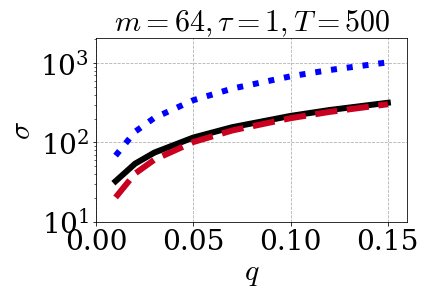

In [10]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
import numpy as np


plt.figure(figsize=(6, 4.2))

plt.rcParams['mathtext.fontset'] = 'cm'


{'cursive', 'fantasy', 'monospace', 'sans', 'sans serif', 'sans-serif', 'serif'}

hfont = {'fontname':'serif'}

plt.xlabel(r'$q$', fontsize=30, **hfont)
plt.xticks(fontsize=28, **hfont)
plt.ylabel(r'$\sigma$', fontsize=30)
plt.yticks(fontsize=28, **hfont)

plt.plot(q_list, naive_list, lw=6, label='Baseline', c='b', ls=':')
plt.plot(q_list, upd_list, lw=6, label='Ours', c='black')
plt.plot(q_list, lbd_list, lw=6, label='Lower Bound', c='#ca0020', ls='--')

plt.grid(axis='x',linestyle='--')
plt.grid(axis='y',linestyle='--')



plt.yscale('log', base=10)
#plt.xscale('log', base=10)

plt.gca().xaxis.set_major_locator(MultipleLocator(0.05))
#plt.gca().yaxis.set_major_locator(MultipleLocator(0.03))

plt.ylim((10, naive_list[-1]*2.0))

plt.xlim((0, 0.16))

plt.title(r'$m={}, \tau={}, T={}$'.format(m, tau, iters), fontsize = 30)


plt.tight_layout()


#plt.savefig('figures/sgm_rdp_q.jpg', dpi=300)
#plt.savefig('figures/sgm_rdp_q.pdf', format='pdf', transparent=True)

plt.show()

## Varying $T$

In [11]:
#alpha = 16
m = 64
q = 0.03

iters = 500


alpha = 4
tau = 1

delta = 1e-5

T_list = [10, 50, 100, 500, 1000, 5000, 10000]

naive_list = []
upd_list = []
lbd_list = []

for iters in T_list:
    naive = calibrating_sgm_noise_naive(q, m, alpha=alpha, tau=tau, t=iters, err=1e-1)
    upd = calibrating_sgm_noise_ours(q, m, alpha=alpha, tau=tau, t=iters, err=1e-1)
    lbd = calibrating_sgm_noise_lbd(q, m, alpha=alpha, tau=tau, t=iters, err=1e-1)
    print("T={}, naive={},upd={},lbd={}".format(iters, naive, upd, lbd))
    print("")
    naive_list.append(naive)
    upd_list.append(upd)
    lbd_list.append(lbd)

T=10, naive=29.17578125,upd=11.884765625,lbd=9.0162353515625

T=50, naive=64.900390625,upd=24.1484375,lbd=19.3880615234375

T=100, naive=91.712890625,upd=33.74609375,lbd=27.3194580078125

T=500, naive=204.98046875,upd=74.7265625,lbd=60.799102783203125

T=1000, naive=289.8359375,upd=105.5,lbd=85.96603393554688

T=5000, naive=648.072265625,upd=235.677734375,lbd=192.0484619140625

T=10000, naive=916.42578125,upd=333.177734375,lbd=271.5912170410156



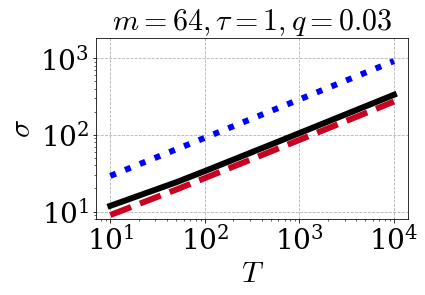

In [12]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
import numpy as np


plt.figure(figsize=(6, 4.2))

plt.rcParams['mathtext.fontset'] = 'cm'


{'cursive', 'fantasy', 'monospace', 'sans', 'sans serif', 'sans-serif', 'serif'}

hfont = {'fontname':'serif'}

plt.xlabel(r'$T$', fontsize=30, **hfont)
plt.xticks(fontsize=28, **hfont)
plt.ylabel(r'$\sigma$', fontsize=30)
plt.yticks(fontsize=28, **hfont)

plt.plot(T_list, naive_list, lw=6, label='Baseline', c='b', ls=':')
plt.plot(T_list, upd_list, lw=6, label='Ours', c='black')
plt.plot(T_list, lbd_list, lw=6, label='Lower Bound', c='#ca0020', ls='--')

plt.grid(axis='x',linestyle='--')
plt.grid(axis='y',linestyle='--')



plt.yscale('log', base=10)
plt.xscale('log', base=10)

#plt.gca().xaxis.set_major_locator(MultipleLocator(0.03))
#plt.gca().yaxis.set_major_locator(MultipleLocator(0.03))

plt.ylim((8, naive_list[-1]*2))

#plt.xlim((0, 2700))

plt.title(r'$m={}, \tau={}, q={}$'.format(m, tau, q), fontsize = 30)


plt.tight_layout()


#plt.savefig('figures/sgm_rdp_T.jpg', dpi=300)
#plt.savefig('figures/sgm_rdp_T.pdf', format='pdf', transparent=True)

plt.show()